In [97]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import linalg as LA
import scipy.sparse as sp
import scipy.sparse.linalg as SLA

# HW3-Nonlinear 2-D problem with variable coefficients 

## Part0: Problem set

Write a solver for the regularized $p$-Laplacian,
$$ -\nabla\cdot\big( \kappa(\nabla u) \nabla u \big) = 0 $$
where
$$ \kappa(\nabla u) = \big(\frac 1 2 \epsilon^2 + \frac 1 2 \nabla u \cdot \nabla u \big)^{\frac{p-2}{2}}, $$
$ \epsilon > 0$, and $1 < p < \infty$.  The case $p=2$ is the conventional Laplacian. This problem gets more strongly nonlinear when $p$ is far from 2 and when $\epsilon$ approaches zero. The $p \to 1$ limit is related to plasticity and has applications in non-Newtonion flows and structural mechanics.

1. Implement a "Picard" solver, which is like a Newton solver except that the Jacobian is replaced by the linear system
$$ J_{\text{Picard}}(u) \delta u \sim -\nabla\cdot\big( \kappa(\nabla u) \nabla \delta u \big) . $$
This is much easier to implement than the full Newton linearization.  How fast does this method converge for values of $p < 2$ and $p > 2$?

* Use the linearization above as a preconditioner to a Newton-Krylov method.  That is, use [`scipy.sparse.linalg.LinearOperator`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.LinearOperator.html) to apply the Jacobian to a vector
$$ \tilde J(u) v = \frac{F(u + h v) - F(u)}{h} . $$
Then for each linear solve, use [`scipy.sparse.linalg.gmres`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.gmres.html) and pass as a preconditioner, a direct solve with the Picard linearization above. (You might find [`scipy.sparse.linalg.factorized`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.factorized.html) to be useful. Compare algebraic convergence to that of the Picard method.

* Can you directly implement a Newton linearization?  Either do it or explain what is involved.  How will its nonlinear convergence compare to that of the Newton-Krylov method?

## Part1: Discretization and Differentiation

In this problem, we consider the domain $\Omega$ as: $$ \Omega = (0, 1) \times (0, 1) $$ and the homogeneous Dirichlet boundary conditions enforced on each side. The Residual as: $$F(u) = -\nabla\cdot\big( \kappa(\nabla u) \nabla u \big) - f $$ Note that in order to make the iterative solver to work, the forcing term $f$ can not be set to zero.

The nonlinear solver defined by the Picard linearization as:$$-\nabla\cdot\big( \kappa(\nabla u) \nabla \delta u \big) = -F(u)$$ 

$$u \gets u + \delta u$$ Firstly, we change $p$ from $2$ to the number away from 2 in order to see the change of convergence rate, then we also alter the $\epsilon$ to observe how the solver works. $\kappa$ in this problem is a function of $\nabla u$, so we will choose more stencil points to evalute $\kappa$.

The discretization and differentiation of the equation as below and note that all the differentiations are in the second order accuracy.

 0: anorm 1.000000e+00
 1: anorm 6.293014e-02
 2: anorm 2.186779e-03
 3: anorm 7.387516e-05
 4: anorm 2.028884e-06
 5: anorm 5.112225e-08
 6: anorm 1.225213e-09


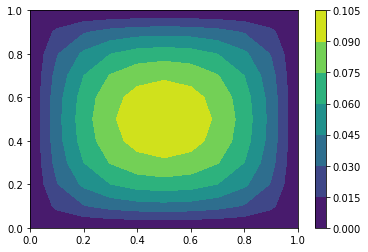

In [98]:
'''The code in this homework refers to the code in FD2D and AlgebraicSolver notebook, and implementing the information in the problem setting'''
def hgrid(h):         # this function computes the mesh info
    m = int(1/h + 1)  # Number of grids point in each direction
    h = 1/(m-1)       # actual grid size
    c = np.linspace(0, 1, m)
    y, x = np.meshgrid(c, c) # generating the grid points
    return x, y

def p_laplacian(id, h, x, y, eps, p ,u_0, rhs, g, dirichlet = ((),())):
    '''h is the uniform grid size for both x and y direction, eps,p are the parameter of k,
       u_0 is the initial guess, rhs is the forcing term which is 0 in this problem,
       and consider dirichlet boundary conditions enforced on all sides'''
# initializing stuff
    m = x.shape[0]     # number of grids in each direction
    g   =  g(x, y).flatten()   # compute Dirichlet array
    F   = -rhs(x, y).flatten() # initialize the residual as -rhs
    u_0 =  u_0.flatten()       # get initial guess array
    ai = []                  # COO format_x_coordinate
    aj = []                  # COO format_y_coordinate
    av = []                  # COO_format_value of the entry
    # the global index of points
    def idx(i, j):
        i = (m-1) - abs(m-1 - abs(i))
        j = (m-1) - abs(m-1 - abs(j))
        return i*m + j
     # the trial array for dirichlet BC
    mask = np.ones_like(x,dtype=bool) # decide if the point hits the Dirichlet boundary,if it is, assigning False value
    mask[dirichlet[0],:] = False  
    mask[:,dirichlet[1]] = False
    mask = mask.flatten()
    F[mask == False] = u_0[mask == False] - g[mask == False] # the residual vector at Dirichlet boundary, and this value tends to 0
    u_0[mask == False] = g[mask == False]  # replace the location of initial guess where lives in the dirichlet boundary

    # Looping over the grids
    for i in range(m):
        for j in range(m):
            row = idx(i, j)
            #this time we have to put a 9-point stencil to compute kappa and 5-point stencil to compute flux
            stencili_k   = np.array([idx(*pair) for pair in [(i-1, j+1), (i-1, j), (i-1, j-1), 
                                         (i, j-1), (i, j), (i,j+1), (i+1,j+1), (i+1,j), (i+1,j-1)]])

            stencili     = np.array([idx(*pair) for pair in [(i-1, j), (i, j-1), (i, j),(i,j+1),(i+1,j)]])
            div = np.array([-1, -1, 1, 1]) / h


            # compute grad of u w.r.t to x
            grad_kx   = np.array([[0, -1, 0, 0, 0, 0, 0, 1, 0],         # stag_1  L
                                [0, -1/2, -1/2, 0, 0, 0, 0, 1/2, 1/2],  # stag_2  D
                                [-1/2, -1/2, 0, 0, 0, 0, 1/2, 1/2, 0],  # stag_3  T
                                [0, -1, 0, 0, 0, 0, 0, 1, 0]])/2/h      # stag_4  R

            # compute grad of u w.r.t to y
            grad_ky   = np.array([[1/2, 0, -1/2, -1/2, 0, 1/2, 0, 0, 0], # stag_1  L
                                [0, 0, 0, -1, 0, 1, 0, 0, 0],            # stag_2  D
                                [0, 0, 0, -1, 0, 1, 0, 0, 0],            # stag_3  T
                                [0, 0, 0, -1/2, 0, 1/2, 1/2, 0, -1/2]])/2/h # stag_4  R

            # Stencil to evaluate gradient at four staggered points
            grad = np.array([[-1, 0, 1, 0, 0],                  # stag_1  L
                            [0, -1, 1, 0, 0],                   # stag_2  D
                            [0, 0, -1, 1, 0],                   # stag_3  T
                            [0, 0, -1, 0, 1]]) / h              # stag_4  R


            #compute the full gradient
            grad_k   = grad_kx + grad_ky # the full grad for each staggered point
            ustencil_k        = u_0[stencili_k]     # our nine points
            stgu = grad_k @ ustencil_k       # our grad(u) at 4 staggered points
            kappa = ((0.5*eps**2+0.5*stgu**2)**(p/2-1)) 


            if mask[row] == 0: # Dirichlet boundary
                ai.append(row)
                aj.append(row)
                av.append(1) # value the diag to 1, for the location in Dirichlet Boundary
            else:
                ustencil = u_0[stencili]   # our five point stencil

                F[row] -= div @ (kappa[:,None] * grad @ ustencil) #update residual on the rhs
                if id ==0:  #the jacobian operator based on the picard solver
                    Jstencil = -div @ (kappa[:,None] * grad)               
                if id ==1:  #the jacobian operator based on the Newton solver
                    Jstencil = -div @ (kappa[:,None] * grad + ((p-2)/2*((0.5*eps**2+ (stgu)**2)**((p-4)/2))[:,None]* (grad @ ustencil)) * stgu @ grad)          
                # start to form the J opeartor
                smask = mask[stencili]
                ai += [row]*sum(smask)
                aj += stencili[smask].tolist()
                av += Jstencil[smask].tolist()

    J = sp.csr_matrix((av, (ai, aj)), shape=(m*m,m*m))
    return F, J

def iter_test(id, eps, p, h, g, dirichlet, atol=1e-8, verbose=False):      # our iterative solver
    x, y = hgrid(h)
    u_0 = 0*x                    # the initial guess
    for i in range(50):          #maximum iterations
        F, J = p_laplacian(id, h, x, y, eps, p, u_0, lambda x,y: 0*x+1,
                           g=g,  dirichlet=dirichlet)
        anorm = LA.norm(F, np.inf)
        if verbose:
            print('{:2d}: anorm {:8e}'.format(i,anorm))
        if anorm < atol:
            break
        deltau = SLA.spsolve(J, -F)
        u_0 += deltau.reshape(x.shape)
    return x, y, u_0, i

x, y, u, i = iter_test(0, 1, 3, .1, lambda x,y: 0*x+0, dirichlet=((0,-1),(0,-1)),verbose=True)
plt.contourf(x, y, u)
plt.colorbar()
plt.show()

    

From the figure above, we can see for for $\epsilon = 1$, $p = 3$, and choose the grid size as $h = 0.1$, a nearly linear convergence rate is presented.

## Part2: The effect of p

Text(0,0.5,'number of iterations')

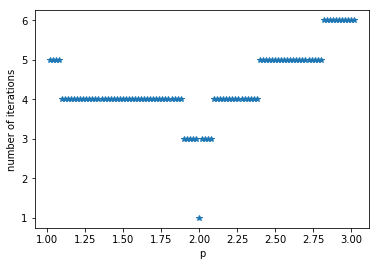

In [99]:
x = []     #value  of p
y=  []     #number of iterations
for p in range(0,101):
    p = 1.02+0.02*p
    x.append(p)
    _, _, _, i = iter_test(0,1, p, .1, lambda x,y: 0*x+0, dirichlet=((0,-1),(0,-1)),verbose=False)
    y.append(i)
plt.plot(x,y,'*')
plt.xlabel('p')
plt.ylabel('number of iterations')


From the figure above, we can see when the $p$ is away from 2, the number of steps used to converge in a given torlence tends to increase, and when $p = 2$, which is the conventional laplacian case, the fastest convergence rate is shown. Plus, for the smaller increment of p (0.02 in this case), the number of steps for a convergence shows the "stepping" phenomenon, which may show the p-laplacian's sensitivity to its power.

## Part3: The effect of $\epsilon$

Text(0,0.5,'number of iterations')

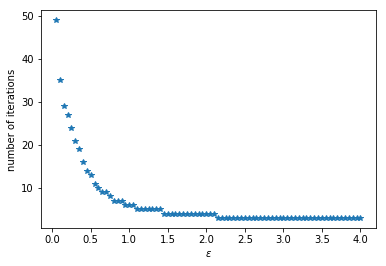

In [100]:
x = []     #value  of eps
y=  []     #number of iterations
for eps in range(0,80):
    eps = 0.05+0.05*eps
    x.append(eps)
    _, _, _, i = iter_test(0, eps, 3, .1, lambda x,y: 0*x+0, dirichlet=((0,-1),(0,-1)),verbose=False)
    y.append(i)
plt.plot(x,y,'*')
plt.xlabel('$\epsilon$')
plt.ylabel('number of iterations')


From the figure above, we can see when $\epsilon$ is approaching to 0, the number of steps for a convergence surges, which means a lower convergence rate. Besides, for a fixed $p$, and when $\epsilon$ is approximately larger than 2.5, we may assume no effect of $\epsilon$ to the convergence rate.

## Part4: Newton-Krylov method with matrix-free Jacobian

In this part, we are going to use Newton-Krylov method implement the gmres method, the grid size, and parameters of computing the residual are the same as the Picard method.

Newton 0 anorm 2.60e-01 rnorm 2.89e-02
Newton 1 anorm 4.66e-04 rnorm 5.18e-05
Newton 2 anorm 1.11e-06 rnorm 1.23e-07
Newton 3 anorm 4.45e-07 rnorm 4.94e-08
Newton 4 anorm 2.62e-07 rnorm 2.91e-08
Newton 5 anorm 1.82e-07 rnorm 2.02e-08
Newton 6 anorm 1.38e-07 rnorm 1.54e-08
Newton 7 anorm 1.13e-07 rnorm 1.25e-08
Newton 8 anorm 9.59e-08 rnorm 1.07e-08
Newton 9 anorm 8.46e-08 rnorm 9.40e-09


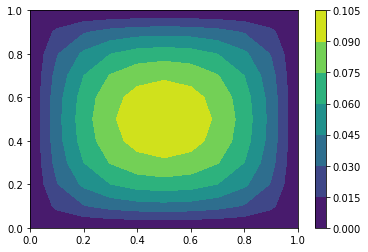

In [101]:
def NK_p_laplacian(h,x,y,eps,p,u0, epsilon=1e-8, rtol=1e-10, maxit=50, verbose=False):
    '''h,x,y,eps,p,u0 are the data to compute the residual vector F(u) at some state variable u
       epsilon is used in the Newton-Krylov method, maximum iteration = 50'''
    u = u_0.copy()
    # we use initial guess to compute initial residual vector
    Fu, _ = p_laplacian(0,h, x, y, eps, p ,u_0, lambda x,y:  0*x+1, 
                        lambda x,y:  0*x , dirichlet = ((0,-1),(0,-1)))
    # compute the norm of error of the initial residual vector
    norm0 = LA.norm(Fu)
    u = u.flatten()
    
    # compute the Jacobian function
    for i in range(maxit):
        # for all vector v, the jacobian operator will compute [F(u+ev)-F(u)]/e
        def Ju_fd(v):
            # the initial v is 0
            F_e,_ = p_laplacian(0,h, x, y, eps, p ,(u+epsilon*v).reshape(x.shape), lambda x,y:  0*x+1, 
                        lambda x,y:  0*x , dirichlet = ((0,-1),(0,-1)))
            return (F_e - Fu) / epsilon  # given a vector v, return an another vector
        # the jacobian opeartor
        Ju = SLA.LinearOperator(((len(Fu),len(u))), matvec=Ju_fd)  
        du, info = SLA.gmres(Ju, Fu, atol=1.e-6)
        
        if info != 0:
            print(LA.norm(Ju @ du - Fu), norm)
            raise RuntimeError('GMRES failed to converge: {:d}'.format(info))
        u -= du
        Fu,_ = p_laplacian(0,h, x, y, eps, p ,u.reshape(x.shape), lambda x,y:  0*x+1, 
                        lambda x,y:  0*x , dirichlet = ((0,-1),(0,-1)))

        norm = LA.norm(Fu)
        if verbose:
            print('Newton {:d} anorm {:6.2e} rnorm {:6.2e}'
                  .format(i, norm, norm/norm0))
        if norm < rtol * norm0:
            break
    return u, i


h    = 0.1
x,y  = hgrid(h) 
u_0  = 0*x
eps  = 1
p    = 3
u_nk,num = NK_p_laplacian(h,x,y,eps,p,u_0, rtol=1e-8, verbose=True)

plt.contourf(x, y, u_nk.reshape(x.shape))
plt.colorbar()
plt.show()



Some interesting phenomenon occur in this case, 

1: If the absolute tolerance setting of the grmes function is less then $10^{-6}$, then the grmes solver fails to converge.

2: The Newton-Krylov method tends to converge faster than the Picard solver in the first a few steps, but it becomes relatively slower when the computation proceeds.

3: When the absolute tolerance reaches about $10^{-7}$, the accuracy of the Newton-Krylov method increses slowly, while the Picard solver can achieve more accuracy during each iteration.

## Part5: Newton linearization

The only difference between the Newton linearization and the Picard linearization is the Jacobian stencil. For Picard's method, the $\kappa$ is not differentiated with respect of u, while the Newton solver does that. In order to make a comparison with the two methods, we introduce an indicator $id$ in the former code, if $id = 0$, we compute the Picard solver, if $id = 1$, we compute the Newton linearization.

In the symbolic way, we compute the Jacobian for Newton solver as:
$$F(u) = -\nabla\cdot\big( \kappa(\nabla u) \nabla u \big) - f $$ 

$$\frac{dF(u)}{du} = -\frac{\nabla\cdot\big(d(\kappa(\nabla u)\nabla u))}{du}$$

$$\frac{dF(u)}{du} = -\nabla\cdot((\kappa\nabla)+\frac{d\kappa}{du}\nabla u)$$

where in the p-laplacian setting:

$$ \kappa(\nabla u) = \big(\frac 1 2 \epsilon^2 + \frac 1 2 \nabla u \cdot \nabla u \big)^{\frac{p-2}{2}}, $$

where in the code, $\kappa = ((0.5eps^2+0.5stgu^2)^{(p/2-1))}$, so:

$$\frac{d\kappa}{du} = \frac{p-2}{2}(0.5eps^2+0.5stgu^2)^{\frac{p-4}{2}}\frac{dstgu}{du}$$ 
After implementing to the code, the convergence test as below:





 0: anorm 1.000000e+00
 1: anorm 6.293014e-02
 2: anorm 2.413306e-03
 3: anorm 7.028249e-05
 4: anorm 1.952157e-06
 5: anorm 4.729247e-08
 6: anorm 1.067534e-09


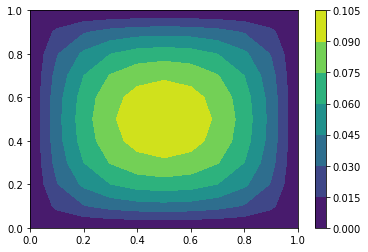

In [102]:
x, y, u, i = iter_test(1, 1, 3, .1, lambda x,y: 0*x+0, dirichlet=((0,-1),(0,-1)),verbose=True)
plt.contourf(x, y, u)
plt.colorbar()
plt.show()

From the result of the Newtwon linearization, we can see similar convergence rate as the Picard solver. Thus, when it comparing to the Newton-Krylov method, at first, the N-K method has a faster convergence, but in the end, the Newton solver gains more accuracy.